Использовать датасет Iris для обучения модели искусственной нейронной сети с помощью pytorch. Разделить выборку на train, val, test. Обучать с помощью градиентного спуска используя categorical_crossentropy loss и функции backward(). Во время валидации и теста посчитать также метрики, такие как accuracy, precision, recall.

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from torch.autograd import Variable
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from pandas.plotting import scatter_matrix
from torch import optim
from torchviz import make_dot

from pytorch_lightning.metrics.functional import precision_recall
from pytorch_lightning.metrics.functional import accuracy
       


%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 12, 6

In [2]:
#loading dataset
iris = load_iris()

df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])

df = df.sample(frac = 1)
df_y_ =df['target']
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
41,4.5,2.3,1.3,0.3,0.0
23,5.1,3.3,1.7,0.5,0.0
146,6.3,2.5,5.0,1.9,2.0
61,5.9,3.0,4.2,1.5,1.0
19,5.1,3.8,1.5,0.3,0.0
...,...,...,...,...,...
79,5.7,2.6,3.5,1.0,1.0
8,4.4,2.9,1.4,0.2,0.0
108,6.7,2.5,5.8,1.8,2.0
106,4.9,2.5,4.5,1.7,2.0


In [3]:
df = df.iloc[:, :-1]
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
41,4.5,2.3,1.3,0.3
23,5.1,3.3,1.7,0.5
146,6.3,2.5,5.0,1.9
61,5.9,3.0,4.2,1.5
19,5.1,3.8,1.5,0.3
...,...,...,...,...
79,5.7,2.6,3.5,1.0
8,4.4,2.9,1.4,0.2
108,6.7,2.5,5.8,1.8
106,4.9,2.5,4.5,1.7


In [4]:
df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [5]:
df.corr()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
sepal length (cm),1.000000,-0.117570,0.871754,0.817941
sepal width (cm),-0.117570,1.000000,-0.428440,-0.366126
petal length (cm),0.871754,-0.428440,1.000000,0.962865
petal width (cm),0.817941,-0.366126,0.962865,1.000000


In [6]:
# plot = scatter_matrix(df, c=iris['target'],marker='o', s=11,alpha=.9)

In [7]:
df_x_train = df[:100]
df_x_val = df[100:125]
df_x_test = df[125:150]

df_y_train = df_y_ [:100]
df_y_val = df_y_ [100:125]
df_y_test = df_y_ [125:150]


In [8]:
x_train = torch.tensor(df_x_train.values, requires_grad =True, dtype=torch.float)
x_val = torch.tensor(df_x_val.values, requires_grad =True, dtype=torch.float)
x_test = torch.tensor(df_x_test.values, requires_grad =True, dtype=torch.float)

y_train = torch.tensor(df_y_train.values, dtype=torch.long)
y_val = torch.tensor(df_y_val.values, dtype=torch.long)
y_test = torch.tensor(df_y_test.values, dtype=torch.long)


In [9]:
class Iris(nn.Module):
    
    #define the init method for the class:
    def __init__(self):
        super().__init__()
        
        #We need to define the layers for our model within init. 
        #The first hidden layer looks like the following:
        self.hidden1 = nn.Linear(4, 10)        
        
        #Then we will define our output layer:
        self.output = nn.Linear(10, 3)
        
        #We will define our softmax activation for our last layer:
        self.softmax = nn.Softmax(dim=1)
        
        #Finally, we will define the activation function in the inner layers:
        self.activation = nn.ReLU()
    
    #Let's start with the forward() method in the class, passing in the input:
    def forward(self, x):
        
        #Now we will move the input to the first hidden layer, with 256 nodes:
        x = self.hidden1(x)
        
        #Next, we pass the outputs from the first hidden layer through the activation
        #function, which in our case is ReLU:
        x = self.activation(x)       
        
        #Now we pass the last output layer, with 10 output classes:
        x = self.output(x)
        
        #Then we will push the output using the softmax function
        output = self.softmax(x)
        
        #Finally, we return the output tensor:
        return output 

model = Iris()
print(model)    

Iris(
  (hidden1): Linear(in_features=4, out_features=10, bias=True)
  (output): Linear(in_features=10, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
  (activation): ReLU()
)


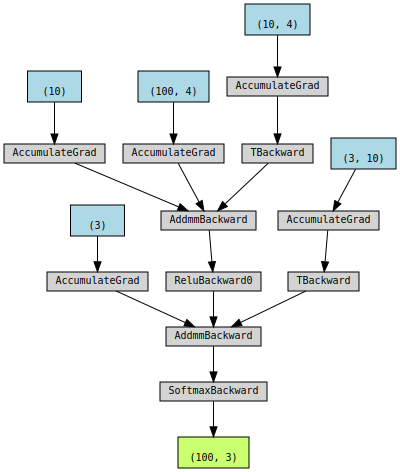

In [10]:
make_dot(model(x_train))

In [11]:
#add the learning rate as an additional parameter:

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

criterion = nn.CrossEntropyLoss()


In [12]:
#Now we will start training our model, starting with the number of epochs:
epoch = 10

history = []

for _ in range(epoch):
    
    #We will iterate through each image in training the image loader, which we defined
    #in an earlier recipe in this chapter: Defining the neural network class:
    
    for i in range(0,len(y_train)):
       
        #Then we get the prediction from the model:
        pred = model(x_train)
        
        #Then we calculate the loss/error:
        loss = criterion(pred, y_train)
        history.append(loss.item())

        # calc gradients
        optimizer.zero_grad()
        loss.backward()
        
        #Then we call the .step() method on the optimizer:
        optimizer.step()     
        
        #Finally, we will print the loss after each epoch:
#     print(f'\t loss: {loss.item()}')

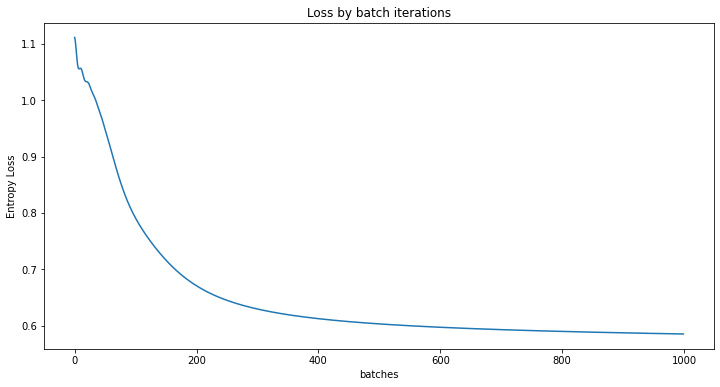

In [13]:
plt.plot(history)

plt.title('Loss by batch iterations')
plt.ylabel('Entropy Loss')
plt.xlabel('batches')

plt.show()

In [14]:
#Train
from pytorch_lightning.metrics.functional import accuracy

y_pred = model(x_train).round()

res = []
for i in y_pred.tolist():
    for j in range(0,3):
        if i[j] == 1.0:
            res.append(j)
        else:
            pass
        
res = torch.tensor(res)


precision, recall = precision_recall(res, y_train, average='macro', num_classes=3)

#print(f"precision: {round(precision.item()*100,1)} %\nrecall: {round(recall.item()*100,1)} %")
accuracy = accuracy(res, y_train).item()

print(f"precision: {round(precision.item()*100,1)} %\nrecall: {round(recall.item()*100,1)} % \
\naccuracy: {round(accuracy*100,1)} %")

precision: 98.1 %
recall: 98.2 % 
accuracy: 98.0 %


In [15]:
#Validation
from pytorch_lightning.metrics.functional import accuracy

y_pred = model(x_val).round()

res = []
for i in y_pred.tolist():
    for j in range(0,3):
        if i[j] == 1.0:
            res.append(j)
        else:
            pass

        
res = torch.tensor(res)

precision, recall = precision_recall(res, y_val, average='macro', num_classes=3)

accuracy = accuracy(res, y_val).item()

print(f"precision: {round(precision.item()*100,1)} %\nrecall: {round(recall.item()*100,1)} % \
\naccuracy: {round(accuracy*100,1)} %")


precision: 96.3 %
recall: 94.4 % 
accuracy: 96.0 %


In [16]:
#Test
from pytorch_lightning.metrics.functional import accuracy

y_pred = model(x_test).round()

res = []
for i in y_pred.tolist():
    for j in range(0,3):
        if i[j] == 1.0:
            res.append(j)
        else:
            pass

pred_test = torch.tensor(res)

precision, recall = precision_recall(pred_test, y_test, average='macro', num_classes=3)

accuracy = accuracy(pred_test, y_test).item()

print(f"precision: {round(precision.item()*100,1)} %\nrecall: {round(recall.item()*100,1)} % \
\naccuracy: {round(accuracy*100,1)} %")


precision: 96.3 %
recall: 94.4 % 
accuracy: 96.0 %


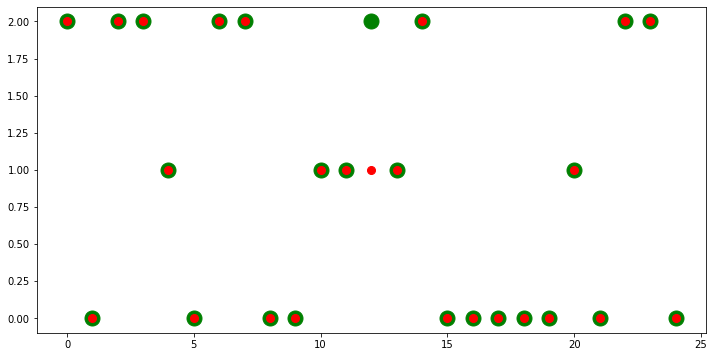

In [17]:
plt.plot(res,'o',color='green',markersize=15)
plt.plot(y_test.tolist(),'o',color='red',markersize=8)
plt.show()